In [67]:
import numpy as np
import pandas as pd
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import pathlib
import cv2
import os
import shutil
import re
import time

import random

## Plan 

1) division des données

2) generation d'images via gan

3) 1er modele et resultat

4) amélioration de la qualité des images via vae

5) 1er modèle entrainer sur les images améliorer

6) Prédiction avec YOLO

## Division des données

Nous disposant de 4 dossiers contenant chacune une catégorie d'image.
* MildDemented contient 896 fichier
* ModerateDemented:64 fichier
* NonDemented: 3200 fichier
* VeryMildDemented: 2240 fichier

On remarque que les classes sont désequilibré notamment pour la catégorie ModerateDemented qui n'a que 64 images. 


Commençons par scindé ces dossiers en 3 dossiers afin d'avoir un jeu de donnée pour les étapes de validation, d'entrainement et de test.

In [ ]:

# On renomme les images afin de facilité la réorganisation
path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
cat=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    cat.append(re.sub("\\\\","/",dirname).split('/')[-1])


del cat[0]    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
k=0 #Accumulateur pour parcourir la liste des labels
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        for file in filenames:
            a=re.sub("\\\\","/",os.path.join(pat,file))
            b=re.sub("\\\\","/",os.path.join(pat,cat[k]+str(j)+'.jpg'))
            #os.rename(a,b)
            j+=1
    k+=1

#Créations de liste contenant les différents composante des futurs chemin d'accés
l=[]
cat=[]
for dirname ,_, filenames  in os.walk(path):
    cat.append(dirname.split("\\")[-1])
    l.append(dirname)
del cat[0]
a=["train_dir","validation_dir","test_dir"]


#Renommons toutes les fichier de chaque dossier afin de faciliter le copie.


#Création des dossier vide et copie des images
path2=re.sub("\\\\","/",os.path.join(path,"SplitData"))
os.mkdir(path2)

for A in a:
    os.mkdir(re.sub("\\\\",'/',os.path.join(path2,A)))

for i in cat:
    p0=re.sub("\\\\","/",os.path.join(path,i))
    n=len(os.listdir(p0))#compte le nombre d'element du fichier i
    fnames=os.listdir(p0)
    for j in a:
        p=re.sub("\\\\","/",os.path.join(path2,j,i))
        os.mkdir(str(p))
            #fnames=['{}.jpg' for k in range(0,2*n//4)]# 50% des données serviront à l'entrainement.
        if j=="train_dir":
            for k in range(0,2*n//4):
            #for fname in fnames:
                src=re.sub("\\\\","/",os.path.join(p0,fnames[k]))
                dst=re.sub("\\\\","/",os.path.join(p,i+str(k)+".jpg"))
                os.renames(src,dst)
        elif j=='validation_dir':
            for k in range(2*n//4,3*n//4):
           # fnames=['{}.jpg' for k in range(2*n//4,3*n//4)]# 25% des données serviront à la validation.
            #for fname in fnames:
                src=re.sub("\\\\","/",os.path.join(p0,fnames[k]))
                dst=re.sub("\\\\","/",os.path.join(p,i+str(k)+".jpg"))
                os.renames(src,dst)
        elif j=='test_dir':
        #fnames=['{}.jpg' for k in range(3*n//4,n)]# 25% des données serviront à tester le modèle.
       # for fname in fnames:
            for k in range(3*n//4,n):
                src=re.sub("\\\\","/",os.path.join(p0,fnames[k]))
                dst=re.sub("\\\\","/",os.path.join(p,i+str(k)+".jpg"))
                os.renames(src,dst)

## Generation d'image via un réseau GAN

Afin de résoudre le problème des classes déséquilibrés souligné plus tôt, on va créer des images à l'aide d'un réseau GAN.
De plus pour éviter de créer des images appartenant aux autres catégorie nous les utiliserons pour entrainer le discriminant.

(208, 176, 3)

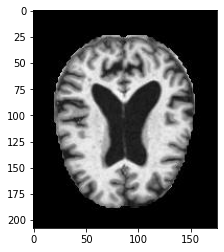

In [2]:
path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
liste=[]
for dirname,_,filenames in os.walk(path):
    #if dirname=='ModerateDemented':
    for file in filenames:
        liste+=[re.sub("\\\\","/",os.path.join(dirname,file))]
im=cv2.imread(liste[0])
plt.imshow(im)
im.shape


In [3]:
def generateur_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(208*176*3, use_bias=False, input_shape=[208,176,3])) #initialisation d'un vecteur bruit
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((208,176,3)))
    
    model.add(layers.Conv2DTranspose(512,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128),(5,5),strides=(2,2),padding="same",use_bias=False)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64),(5,5),strides=(2,2),padding="same",use_bias=False)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    
    return model

def discriminant_model():
    model=tf.keras.Sequential()
  
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=[208,176,3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLu())
    
   
    model.add(layers.Conv2D(256,(5,5),stides(2,2),padding='same')
    model.add(layers.LeakyRelu()) 
    
    model.add(layers.Conv2D(128,(5,5),stides(2,2),padding='same')
    model.add(layers.LeakyRelu()) 
    
    model.add(layers.Conv2D(64,(5,5),stides(2,2),padding='same')
    model.add(layers.LeakyRelu()) 
    model.add(layers.Dense(1,activation'sigmoid'))

SyntaxError: invalid syntax (2791887689.py, line 37)

## Pré traitement des données

Convertissons les images en tenseur.

In [35]:
train_dir="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/SplitData/train_dir"
valid_dir="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/SplitData/validation_dir"
test_dir="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/SplitData/test_dir"

#train_datagen=ImageDataGenerator(rescale=1./255)
#test_datagen=ImageDataGenerator(rescale=1./255)
#valid_datagen=ImageDataGenerator(rescale=1./255)

#train_generator=train_datagen.flow_from_directory(train_dir,target_size=(208,176),batch_size=20,class_mode='categorical')
#test_generator=test_datagen.flow_from_directory(test_dir,target_size=(208,176),batch_size=20,class_mode='categorical')
#valid_generator=valid_datagen.flow_from_directory(valid_dir,target_size=(208,176),batch_size=20,class_mode='categorical')

train_generator=tf.keras.utils.image_dataset_from_directory(train_dir,labels='inferred',image_size=(100, 100),batch_size=32)
test_generator=tf.keras.utils.image_dataset_from_directory(test_dir,labels='inferred',image_size=(100, 100),batch_size=32)
valid_generator=tf.keras.utils.image_dataset_from_directory(valid_dir,labels='inferred',image_size=(100, 100),batch_size=32)

Found 3173 files belonging to 4 classes.
Found 1587 files belonging to 4 classes.
Found 1587 files belonging to 4 classes.


In [36]:
class_names = train_generator.class_names
print(class_names)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


On a bien le bon nombre de label.

## Classification

### Modele de CNN

In [43]:
model=tf.keras.models.Sequential()

model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

#model.build(input_shape=(208, 176, 3))
#model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=["acc"])
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=["acc"])

#tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))

In [48]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=30)
model.save("al")

Epoch 1/30
100/100 [==============================] - 15s 144ms/step - loss: 0.6743 - acc: 0.7056 - val_loss: 1.3766 - val_acc: 0.3648
Epoch 2/30
100/100 [==============================] - 13s 129ms/step - loss: 0.5862 - acc: 0.7428 - val_loss: 1.5020 - val_acc: 0.3573
Epoch 3/30
100/100 [==============================] - 13s 129ms/step - loss: 0.5158 - acc: 0.7806 - val_loss: 1.2583 - val_acc: 0.3856
Epoch 4/30
100/100 [==============================] - 13s 131ms/step - loss: 0.4277 - acc: 0.8276 - val_loss: 1.3501 - val_acc: 0.4222
Epoch 5/30
100/100 [==============================] - 13s 130ms/step - loss: 0.3511 - acc: 0.8679 - val_loss: 1.6050 - val_acc: 0.4354
Epoch 6/30
100/100 [==============================] - 13s 130ms/step - loss: 0.2919 - acc: 0.8872 - val_loss: 1.2662 - val_acc: 0.5633
Epoch 7/30
100/100 [==============================] - 13s 129ms/step - loss: 0.2319 - acc: 0.9114 - val_loss: 1.9978 - val_acc: 0.4707
Epoch 8/30
100/100 [==============================] - 1

In [50]:
train_acc=history.history["acc"]
val_acc=history.history['val_acc']
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]

C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:11: UserWarning: color is redundantly defined by the '

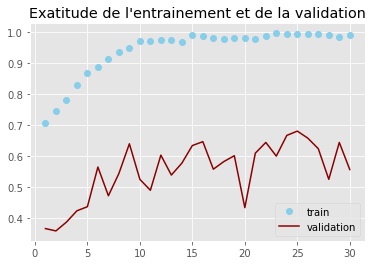

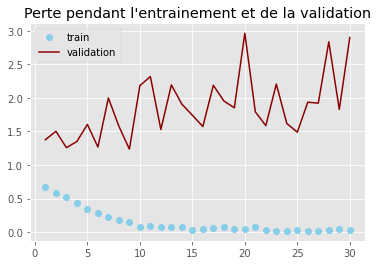

In [57]:
epochs=range(1,len(train_acc)+1)
plt.style.use('ggplot')
plt.figure()
plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
plt.title("Exatitude de l'entrainement et de la validation")
plt.legend()
plt.figure()

plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
plt.plot(epochs,val_loss,'b',label="validation",color="darkred")
plt.title("Perte pendant l'entrainement et de la validation")
plt.legend()

Le modèle est clairement sur ajuster pour y remedier on pourrait rajouter des couches dropout, utiliser les régularisateur ou même faire de la data augmentation.

## Data Augmentation 

In [60]:
modele2=tf.keras.models.Sequential()

modele2.add(layers.Rescaling(1./255))
modele2.add(layers.RandomFlip("horizontal_and_vertical"))
modele2.add(layers.RandomRotation(0.2))


modele2.add(layers.Conv2D(32,(3,3),activation="relu"))
modele2.add(layers.MaxPooling2D((2,2)))
modele2.add(layers.Conv2D(64,(3,3),activation='relu'))
modele2.add(layers.Dropout(0.2))

modele2.add(layers.MaxPooling2D((2,2)))
modele2.add(layers.Conv2D(128,(3,3),activation='relu'))
modele2.add(layers.Dropout(0.2))

modele2.add(layers.MaxPooling2D((2,2)))
modele2.add(layers.Conv2D(128,(3,3),activation='relu'))
modele2.add(layers.MaxPooling2D((2,2)))

modele2.add(layers.Flatten())
modele2.add(layers.Dense(512,activation='relu'))
modele2.add(layers.Dense(4,activation='softmax'))


modele2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=["acc"])

In [61]:
history=modele2.fit(train_generator,validation_data=valid_generator,epochs=30)
modele2.save("al2")

Epoch 1/30
100/100 [==============================] - 20s 177ms/step - loss: 1.0338 - acc: 0.4995 - val_loss: 1.0506 - val_acc: 0.4373
Epoch 2/30
100/100 [==============================] - 14s 141ms/step - loss: 0.9260 - acc: 0.5717 - val_loss: 1.0795 - val_acc: 0.3705
Epoch 3/30
100/100 [==============================] - 14s 139ms/step - loss: 0.8778 - acc: 0.6098 - val_loss: 1.1137 - val_acc: 0.3415
Epoch 4/30
100/100 [==============================] - 14s 139ms/step - loss: 0.8556 - acc: 0.6098 - val_loss: 1.1645 - val_acc: 0.2766
Epoch 5/30
100/100 [==============================] - 14s 137ms/step - loss: 0.8314 - acc: 0.6287 - val_loss: 1.2035 - val_acc: 0.3289
Epoch 6/30
100/100 [==============================] - 14s 138ms/step - loss: 0.8279 - acc: 0.6187 - val_loss: 1.2389 - val_acc: 0.2880
Epoch 7/30
100/100 [==============================] - 14s 137ms/step - loss: 0.7969 - acc: 0.6376 - val_loss: 1.2161 - val_acc: 0.3529
Epoch 8/30
100/100 [==============================] - 1

In [62]:
train_acc=history.history["acc"]
val_acc=history.history['val_acc']
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]

C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1500591430.py:11: UserWarning: color is redundantly defined by the '

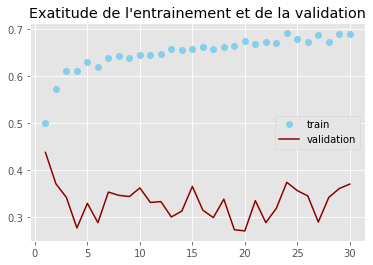

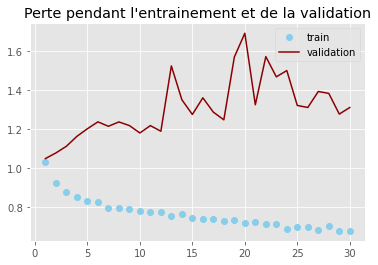

In [63]:
epochs=range(1,len(train_acc)+1)
plt.style.use('ggplot')
plt.figure()
plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
plt.title("Exatitude de l'entrainement et de la validation")
plt.legend()
plt.figure()

plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
plt.plot(epochs,val_loss,'b',label="validation",color="darkred")
plt.title("Perte pendant l'entrainement et de la validation")
plt.legend()

In [70]:
modele3=tf.keras.models.Sequential()

modele3.add(layers.Rescaling(1./255))
modele3.add(layers.RandomFlip("horizontal_and_vertical"))
modele3.add(layers.RandomRotation(0.2))

modele3.add(layers.Dense(16,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
modele3.add(layers.Dense(16,kernel_regularizer=regularizers.l2(0.01),activation='relu'))

modele3.add(layers.Conv2D(32,(3,3),activation="relu"))
modele3.add(layers.MaxPooling2D((2,2)))
modele3.add(layers.Conv2D(64,(3,3),activation='relu'))
modele3.add(layers.Dropout(0.5))

modele3.add(layers.MaxPooling2D((2,2)))
modele3.add(layers.Conv2D(128,(3,3),activation='relu'))
modele3.add(layers.Dropout(0.5))

modele3.add(layers.MaxPooling2D((2,2)))
modele3.add(layers.Conv2D(128,(3,3),activation='relu'))
modele3.add(layers.MaxPooling2D((2,2)))

modele3.add(layers.Flatten())
modele3.add(layers.Dense(512,activation='relu'))
modele3.add(layers.Dense(4,activation='softmax'))


modele3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=["acc"])

history=modele2.fit(train_generator,validation_data=valid_generator,epochs=30)
modele2.save("al2")

Epoch 1/30
100/100 [==============================] - 14s 135ms/step - loss: 0.5588 - acc: 0.7476 - val_loss: 1.6746 - val_acc: 0.3718
Epoch 2/30
100/100 [==============================] - 13s 133ms/step - loss: 0.5564 - acc: 0.7507 - val_loss: 1.4889 - val_acc: 0.3932
Epoch 3/30
100/100 [==============================] - 13s 132ms/step - loss: 0.5471 - acc: 0.7567 - val_loss: 1.4047 - val_acc: 0.4260
Epoch 4/30
100/100 [==============================] - 13s 131ms/step - loss: 0.5446 - acc: 0.7488 - val_loss: 1.4154 - val_acc: 0.3963
Epoch 5/30
100/100 [==============================] - 13s 131ms/step - loss: 0.5237 - acc: 0.7699 - val_loss: 1.3290 - val_acc: 0.4360
Epoch 6/30
100/100 [==============================] - 13s 130ms/step - loss: 0.5288 - acc: 0.7624 - val_loss: 1.6465 - val_acc: 0.3945
Epoch 7/30
100/100 [==============================] - 13s 132ms/step - loss: 0.5422 - acc: 0.7570 - val_loss: 1.4561 - val_acc: 0.4014
Epoch 8/30
100/100 [==============================] - 1

C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1507213709.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1507213709.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1507213709.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
C:\Users\ranus\AppData\Local\Temp\ipykernel_30608\1507213709.py:15: UserWarning: color is redundantly defined by the '

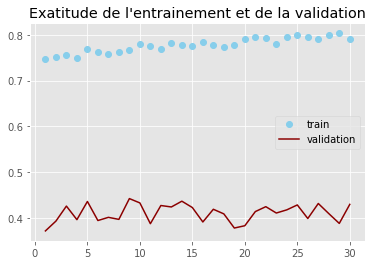

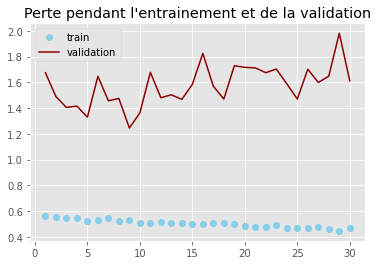

In [71]:
train_acc=history.history["acc"]
val_acc=history.history['val_acc']
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]

plt.style.use('ggplot')
plt.figure()
plt.plot(epochs,train_acc,'bo',label="train",color="skyblue")
plt.plot(epochs,val_acc,'b',label="validation",color="darkred")
plt.title("Exatitude de l'entrainement et de la validation")
plt.legend()
plt.figure()

plt.plot(epochs,train_loss,'bo',label="train",color="skyblue")
plt.plot(epochs,val_loss,'b',label="validation",color="darkred")
plt.title("Perte pendant l'entrainement et de la validation")
plt.legend()

In [ ]:
#path2="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
#image=[]
#categorie=[]
#for dirname, _,filenames in os.walk(path2):
 #   for filename in filenames:
  #      image+=[os.path.join(dirname, filename)]
   #     categorie+=[dirname.split("\\")[-1]]

#df=pd.DataFrame({"images":image,"categories":categorie})
#df=df.sample(frac=1)
#df
#df
#np.random.shuffle(df)

In [ ]:
df["categories"].value_counts()

### Traitement des données

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator

#train_datagen=ImageDataGenerator(rescale=1./255)
#test_datagen=ImageDataGenerator(rescale=1./255)
data_test
def traitement(data):
    for i in range(0,data.shape[0]-1):
        images+=[cv2.imread(data.iloc[i:0])/255]
        labels+=[data.iloc[i:1]]

In [ ]:



path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
label=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    label.append(dirname.split('/')[-1])
    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        a=re.sub("\\\\","/",os.path.join(pat,filenames[j]))
        b=re.sub("\\\\","/",os.path.join(pat.split("/")[-1],str(j)+'.jpg'))
        j+=1
        #print(a)
        #print(b)

In [ ]:
path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        for file in filenames:
            a=os.path.join(pat,file)
            print(re.sub("\\\\","/",a))

## YOLO

In [30]:
print(tf.shape(train_generator.next()[0]))
print(tf.shape(train_generator.next()[1]))


tf.Tensor([ 32 208 176   3], shape=(4,), dtype=int32)
tf.Tensor([32  4], shape=(2,), dtype=int32)
